# Compact Orthogonal Distance Regression

### Notebook settings

In [1]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# Configure plots
%config InlineBackend.figure_formats = 'svg'
%matplotlib inline

In [3]:
# Add src to path to load modules from the package
import sys

sys.path.append("../src")

### Preview dataframe

In [4]:
from sft.data import load_df  # type: ignore

# Load and preview the full dataset
load_df("df_with_fracture_toughness_final_incl_bendingstiffness_final3.pkl").head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,exp_id,date,datetime_x,fieldsite,slope_incl,h_wl_notch,...,GIc_manual_default_min_error,GIIc_manual_default_min_error,Gc_manual_default_min_error,GIIG_manual_default_min_error,slope_incl_min_error,surface_lineload_min_error,GIc_video_seriesopt_min_error,GIIc_video_seriesopt_min_error,Gc_video_seriesopt_min_error,GIIG_video_seriesopt_min_error
0,0,0,0,0,2023_02_15_1,2023-02-15,2023-02-15,2,0.0+/-2.0,13.5,...,0.51+/-0.05,0.0089+/-0.0028,0.51+/-0.06,0.017+/-0.005,0.0+/-2.0,0.000454+/-0.000005,0.283+/-0.013,0.0140+/-0.0018,0.297+/-0.012,0.047+/-0.007
1,1,1,1,1,2023_02_15_2,2023-02-15,2023-02-15,2,-46.0+/-2.0,12.5,...,0.35+/-0.08,0.350+/-0.032,0.70+/-0.09,0.50+/-0.06,-46.0+/-2.0,0.000889+/-0.000009,0.27+/-0.05,0.253+/-0.006,0.52+/-0.05,0.48+/-0.05
2,2,2,2,2,2023_02_15_3,2023-02-15,2023-02-15,2,-56.0+/-2.0,13.0,...,0.19+/-0.07,0.51+/-0.05,0.70+/-0.09,0.73+/-0.07,-56.0+/-2.0,0.000889+/-0.000009,0.32+/-0.09,0.471+/-0.018,0.80+/-0.10,0.59+/-0.06
3,3,3,3,3,2023_02_15_4,2023-02-15,2023-02-15,2,-36.0+/-2.0,13.0,...,0.36+/-0.06,0.213+/-0.021,0.57+/-0.07,0.37+/-0.05,-36.0+/-2.0,0.000889+/-0.000009,0.37+/-0.05,0.205+/-0.005,0.57+/-0.05,0.357+/-0.034
4,4,4,4,4,2023_02_15_5,2023-02-15,2023-02-15,2,-25.0+/-2.0,12.5,...,0.34+/-0.05,0.097+/-0.012,0.44+/-0.05,0.224+/-0.034,-25.0+/-2.0,0.000889+/-0.000009,0.175+/-0.022,0.062+/-0.004,0.237+/-0.019,0.260+/-0.035


### Get only the data relevant for fits

In [45]:
from sft.prepare import build_fracture_toughness_df  # type: ignore

df = build_fracture_toughness_df(
    file="df_with_fracture_toughness_final_incl_bendingstiffness_final3.pkl",
    date_ranges={
        # "series": "date range"
        "1": (None, "2023-02-16"),
        "2": ("2023-02-27", "2023-03-03"),
        "3": ("2023-03-06", "2023-03-08"),
    },
    data_cols={
        # "source": ("GIc_col", "GIIc_col")
        "manual": (
            "GIc_manual_default_min_error",
            "GIIc_manual_default_min_error",
        ),
        "video": (
            "GIc_video_seriesopt_min_error",
            "GIIc_video_seriesopt_min_error",
        ),
    },
)

In [32]:
df

GIc             GIIc
source series                                
manual 1         0.51+/-0.05  0.0089+/-0.0028
       1         0.35+/-0.08    0.350+/-0.032
       1         0.19+/-0.07      0.51+/-0.05
       1         0.36+/-0.06    0.213+/-0.021
       1         0.34+/-0.05    0.097+/-0.012
...                      ...              ...
video  3       0.237+/-0.034    0.126+/-0.004
       3         0.33+/-0.06    0.272+/-0.013
       3       0.461+/-0.030  0.0533+/-0.0028
       3       0.347+/-0.025  0.0348+/-0.0023
       3         1.24+/-0.30      1.36+/-0.14

[240 rows x 2 columns]

### Filter outliers

In [46]:
from sft.prepare import filter_by_gc_threshold  # type: ignore

df = filter_by_gc_threshold(
    df,
    source="manual",
    # gic_max=2,
)

df = filter_by_gc_threshold(
    df,
    source="video",
    gic_max=2,
    # gic_max=0.85,
)

In [47]:
len(df)

238

### Plot data

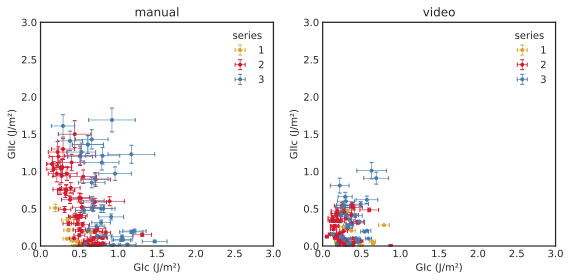

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp

sources = sorted(df.index.get_level_values("source").unique())
series_list = sorted(df.index.get_level_values("series").unique())
palette = [
    "#d3a836",
    "#ce1b30",
    "#447cab",
    "#89c9d9",
    "#77664c",
    "#c99076",
    "#69a0c5",
    "#2d5a7d",
]
colors = {s: palette[i % len(palette)] for i, s in enumerate(series_list)}
limits = (0, 3)

with plt.style.context("seaborn-v0_8-white"):
    fig, axes = plt.subplots(1, len(sources), figsize=(4 * len(sources), 4))
    axes = np.atleast_1d(axes)
    for ax, src in zip(axes, sources):
        for srs in series_list:
            sub = df.loc[(src, srs)]
            x, xerr = unp.nominal_values(sub["GIc"]), unp.std_devs(sub["GIc"])
            y, yerr = unp.nominal_values(sub["GIIc"]), unp.std_devs(sub["GIIc"])
            ax.errorbar(
                x,
                y,
                xerr=xerr,
                yerr=yerr,
                fmt="o",
                ms=3,
                elinewidth=0.6,
                capsize=2,
                color=colors[srs],
                label=srs,
            )
        ax.set(
            title=src,
            xlabel="GIc (J/m²)",
            ylabel="GIIc (J/m²)",
            xlim=limits,
            ylim=limits,
        )
        ax.legend(title="series")

    plt.tight_layout()


## Run ODR with different start values for GIc, GIIc, n, and m

In [ ]:
from sft.regression import parallel_odr

fit_manual = parallel_odr(df, source="manual", max_workers=12)  # 2min 23s on M3 MacBook

GIc     GIIc    DESCRIPTION
---------------------------------------------
0.466   0.546   Series 1 fracture toughnesses
0.631   1.032   Series 2 fracture toughnesses
0.822   1.547   Series 3 fracture toughnesses

EXPONENTS   DESCRIPTION
---------------------------------------------
n   0.129   Mode I interaction-law exponent
m   0.782   Mode II interaction-law exponent

STATISTICS
----------------------------------------------------------------------
chi^2_red    3.029   Residual sum of squares per DOF (goodness of fit)
p-value      0.000   p-value (significant if below 0.05)
R^2          0.248   R-squared (not valid for nonlinear regression)
nDOF           114   n(DOF) as n(used obs) - n(free params)
S_total        345   Total sum of squares (optimization objective)



In [ ]:
from sft.regression import parallel_odr

fit_video = parallel_odr(df, source="video", max_workers=12)  # 1min 54s on M3 MacBook

GIc     GIIc    DESCRIPTION
---------------------------------------------
0.670   0.535   Series 1 fracture toughnesses
0.658   0.489   Series 2 fracture toughnesses
0.511   1.232   Series 3 fracture toughnesses

EXPONENTS   DESCRIPTION
---------------------------------------------
n   0.376   Mode I interaction-law exponent
m   0.802   Mode II interaction-law exponent

STATISTICS
----------------------------------------------------------------------
chi^2_red   15.651   Residual sum of squares per DOF (goodness of fit)
p-value      0.000   p-value (significant if below 0.05)
R^2          0.060   R-squared (not valid for nonlinear regression)
nDOF           112   n(DOF) as n(used obs) - n(free params)
S_total       1753   Total sum of squares (optimization objective)



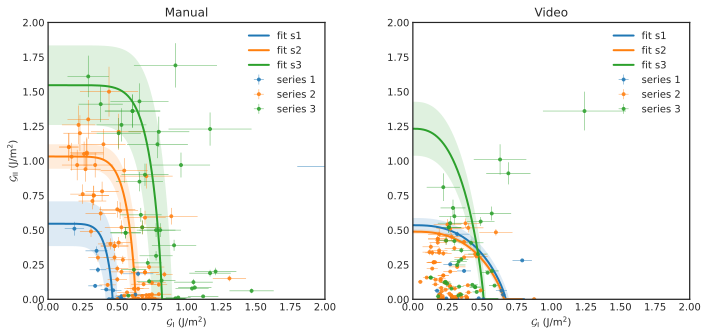

In [78]:
from sft.visualization import plot_side_by_side_series_odr

fig, (ax_m, ax_v) = plot_side_by_side_series_odr(
    df, fit_manual=fit_manual, fit_video=fit_video, ci=0.95, Gmax=2
)

tudu

* which outliers to filter?

## Run ODR with single start value for GIc and GIIc, but different ones for n and m

In [61]:
from sft.regression import odr

fit_manual = odr(df, source="manual")

GIc     GIIc    DESCRIPTION
---------------------------------------------
0.462   0.546   Series 1 fracture toughnesses
0.625   1.032   Series 2 fracture toughnesses
0.812   1.537   Series 3 fracture toughnesses

EXPONENTS   DESCRIPTION
---------------------------------------------
n   0.150   Mode I interaction-law exponent
m   0.400   Mode II interaction-law exponent

STATISTICS
----------------------------------------------------------------------
chi^2_red    3.092   Residual sum of squares per DOF (goodness of fit)
p-value      0.000   p-value (significant if below 0.05)
R^2          0.244   R-squared (not valid for nonlinear regression)
nDOF           114   n(DOF) as n(used obs) - n(free params)
S_total        352   Total sum of squares (optimization objective)



In [67]:
from sft.regression import odr

fit_video = odr(df, source="video")

GIc     GIIc    DESCRIPTION
---------------------------------------------
0.534   0.465   Series 1 fracture toughnesses
0.324   0.510   Series 2 fracture toughnesses
0.351   1.402   Series 3 fracture toughnesses

EXPONENTS   DESCRIPTION
---------------------------------------------
n   0.300   Mode I interaction-law exponent
m   0.800   Mode II interaction-law exponent

STATISTICS
----------------------------------------------------------------------
chi^2_red   63.712   Residual sum of squares per DOF (goodness of fit)
p-value      0.000   p-value (significant if below 0.05)
R^2          0.015   R-squared (not valid for nonlinear regression)
nDOF           112   n(DOF) as n(used obs) - n(free params)
S_total       7136   Total sum of squares (optimization objective)



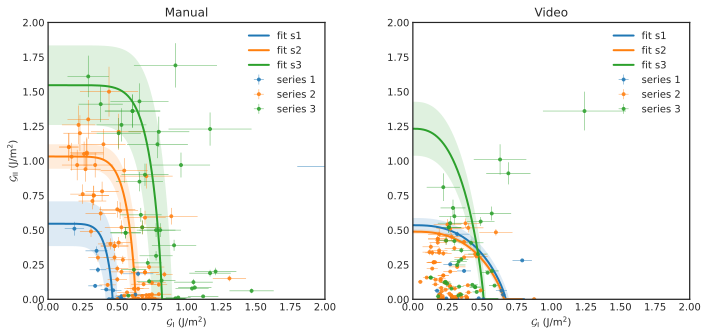

In [77]:
from sft.visualization import plot_side_by_side_series_odr

fig, (ax_m, ax_v) = plot_side_by_side_series_odr(
    df, fit_manual=fit_manual, fit_video=fit_video, ci=0.95, Gmax=2
)